# Basic functionality

In this notebook we demonstrate the basic usage of the MICROtool package. The main usage of MICROtool is to optimize a diffusion imaging acquisition scheme based on a microstructural model. In order to do so the steps to follow are
1. Setup a tissue model
2. Setup an acquisition scheme (it is recommended to choose a scheme to already is a sensible choice for your problem)
3. Optimize the scheme using cramer rao lower bound based optimization
4. (optional) Verify the resulting scheme using monte carlo simulations.


## Setting up the dmipy model

We demonstrate this using a simple model from dmipy

In [13]:
from dmipy.core.modeling_framework import MultiCompartmentModel
from dmipy.signal_models.gaussian_models import G1Ball

from microtool.dmipy import DmipyTissueModel
from microtool.tissue_model import RelaxedMultiTissueModel

# setting up a simple model
simple_ball = G1Ball(lambda_iso=1.7e-9)

# This step is unnecessary
dmipy_model = MultiCompartmentModel([simple_ball])

microtool_model = DmipyTissueModel(dmipy_model)

## Setting up the acquisition scheme

In [2]:
from microtool.dmipy import convert_dmipy_scheme2diffusion_scheme

from microtool.utils.saved_schemes import alexander2008_optimized_directions


acq_scheme = alexander2008_optimized_directions([2,8,16])
acq_wrapped = convert_dmipy_scheme2diffusion_scheme(acq_scheme)
acq_wrapped.fix_b0_measurements()
print(acq_wrapped)

Acquisition scheme with 44 measurements and 6 scalar parameters:
  DiffusionBValue [s/mm²] in (0.0, 20000.0)    DiffusionGradientAnglePhi [rad] (fixed)    DiffusionGradientAngleTheta [rad] (fixed)    DiffusionPulseWidth [ms] in (1.0, 100.0)    DiffusionPulseInterval [ms] in (1.0, 1000.0)    EchoTime [ms] in (0.1, 1000.0)
-------------------------------------------  -----------------------------------------  -------------------------------------------  ------------------------------------------  ----------------------------------------------  --------------------------------
                                          0                                 -1.96142                                       1.98074                                            7                                              12                           36.2367
                                          0                                  2.96645                                       0.952638                              

Now that we have the acquisition scheme and tissue model defined we test the generation of signal.

In [3]:
microtool_model(acq_wrapped)

array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.26539597e-01, 1.26539597e-01,
       2.27448870e-03, 2.27448870e-03, 2.27448870e-03, 2.27448870e-03,
       2.27448870e-03, 2.27448870e-03, 2.27448870e-03, 2.27448870e-03,
       1.49871220e-13, 1.49871220e-13, 1.49871220e-13, 1.49871220e-13,
       1.49871220e-13, 1.49871220e-13, 1.49871220e-13, 1.49871220e-13,
       1.49871220e-13, 1.49871220e-13, 1.49871220e-13, 1.49871220e-13,
       1.49871220e-13, 1.49871220e-13, 1.49871220e-13, 1.49871220e-13])

## Optimizing the scheme with respect to the diffusivity.

In [4]:
from microtool.optimize import optimize_scheme

scheme, _ = optimize_scheme(acq_wrapped, microtool_model, noise_variance=0.02, method=None)

C:\Users\Frank\miniconda3\envs\devmicro\lib\site-packages\scipy\optimize\_constraints.py:446: OptimizeWarning: Constraint options `finite_diff_jac_sparsity`, `finite_diff_rel_step`, `keep_feasible`, and `hess`are ignored by this method.
  warn("Constraint options `finite_diff_jac_sparsity`, "


## Fitting the model

In [5]:
# Generating basic signal on the new scheme
signal = microtool_model(scheme)

fitted_model = microtool_model.fit(scheme, signal)
fitted_model.fitted_parameters

Using parallel processing with 12 workers.
Setup brute2fine optimizer in 0.0 seconds
Fitting of 1 voxels complete in 3.5287551879882812 seconds.
Average of 3.5287551879882812 seconds per voxel.


## Validation of scheme optimization through Monte Carlo simulations

In [ ]:
from microtool.monte_carlo.simulation import MonteCarloSimulation
from microtool.monte_carlo.parameter_distributions import plot_parameter_distributions
from scipy import stats

# loc is mean and scale is standard deviation
noise_distribution = stats.norm(loc=0, scale=0.02)

simulation = MonteCarloSimulation(scheme,microtool_model,noise_distribution,n_sim=100)

simulation.run()

# Its wise to save your simulations, always check before running a simulation that the path is valid! (write a string to it for example)
path = "simulations/basic_functionality.pkl"
simulation.save(path)

# accesing the simulation result is as follows, convenience functions for plotting are also implemented
result = simulation.result
fig = plot_parameter_distributions(result, microtool_model)

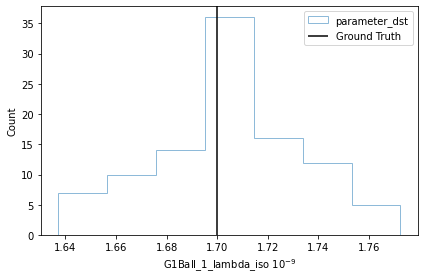

In [18]:
from microtool.utils.IO import get_pickle

result = get_pickle("simulations/basic_functionality.pkl")
fig = plot_parameter_distributions(result, microtool_model)